# CBP Calibration Electrometer CSC

This notebook is used to command the electrometer used to read the solar cell and then also access the data

In [1]:
%matplotlib inline
from lsst.ts import salobj
import asyncio
import os
from astropy.time import Time
import pandas as pd
import numpy as np
import subprocess

from astropy.io import fits
import matplotlib.pyplot as plt


from lsst_efd_client import EfdClient
client = EfdClient('tucson_teststand_efd')

In [2]:
dir_ = '/home/parfa30/DATA/electrometer_files' # directory where data will be saved

In [3]:
sc_electrometer_index = 2
cbp_electrometer_index = 4

### Setup CSC

In [4]:
domain = salobj.Domain()
sc_electrometer = salobj.Remote(name="Electrometer", domain=domain, index=sc_electrometer_index) 
cbp_electrometer = salobj.Remote(name="Electrometer", domain=domain, index=cbp_electrometer_index) 
await sc_electrometer.start_task
await cbp_electrometer.start_task

In [6]:
tmp = await cbp_electrometer.evt_heartbeat.aget()
print(tmp)

salIndex: 4, private_revCode: 7f398fff, private_sndStamp: 1666126613.881732, private_rcvStamp: 1666126613.8832629, private_seqNum: 1151568, private_identity: Electrometer:4, private_origin: 8090, heartbeat: False


In [12]:
tmps = await sc_electrometer.evt_summaryState.aget()
tmpc = await cbp_electrometer.evt_summaryState.aget()
print('Solar Cell: ',salobj.State(tmps.summaryState))
print('CBP: ',salobj.State(tmpc.summaryState))

Solar Cell:  State.ENABLED
CBP:  State.ENABLED


In [8]:
tmp = await cbp_electrometer.evt_detailedState.aget()
print(tmp)

CancelledError: 

In [8]:
tmp = await cbp_electrometer.evt_.aget()
print(tmp)

AttributeError: 'Remote' object has no attribute 'evt_'

In [13]:
tmp=await salobj.set_summary_state(sc_electrometer, salobj.State.ENABLED, override="tts_laser_reference_v3.yaml", timeout=20)
print(tmp)

[<State.ENABLED: 2>]


In [8]:
tmp = await cbp_electrometer.cmd_setIntegrationTime.set_start(intTime=166.67e-6)
print(tmp)

NameError: name 'cbp_electrometer' is not defined

In [32]:
tmp = await cbp_electrometer.cmd_standby.set_start()

In [34]:
# Bring to enabled with proper config file
#tmps=await salobj.set_summary_state(sc_electrometer, salobj.State.ENABLED, override="tts_laser_reference_v3.yaml", timeout=20)
#print(tmps)
tmpc=await salobj.set_summary_state(cbp_electrometer, salobj.State.ENABLED, override="tts_cimacs2_v3.yaml", timeout=20)
print(tmpc)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]


In [44]:
tmp = await cbp_electrometer.cmd_exitControl.set_start()

In [7]:
await sc_electrometer.cmd_performZeroCalib.set_start(timeout=10) #Calibrates the Electrometer
await sc_electrometer.cmd_setDigitalFilter.set_start(activateFilter=False, activateAvgFilter=False, activateMedFilter=False, timeout=10)

#await cbp_electrometer.cmd_performZeroCalib.set_start(timeout=10) #Calibrates the Electrometer
#await cbp_electrometer.cmd_setDigitalFilter.set_start(activateFilter=False, activateAvgFilter=False, activateMedFilter=False, timeout=10)

In [22]:
await sc_electrometer.cmd_setMode.set_start(mode=2) #1=Current, 2=Charge, 3=Voltage, 4=Resistance

In [24]:
await sc_electrometer.cmd_startScan.set_start(timeout=10)
await asyncio.sleep(3)
await sc_electrometer.cmd_stopScan.set_start(timeout=10)

### Take Measurement

In [9]:
elec_id = {2:sc_electrometer}#, 4:cbp_electrometer} #, 5:electrometer5}
async def start_measure(electrometers):
    if isinstance(electrometers, list):
        to_run = []
        for elec in electrometers:
            #await elec_id[elec].cmd_performZeroCalib.set_start(timeout=10)
            to_run.append(elec_id[elec].cmd_startScan.set_start(timeout=10))
        await asyncio.gather(*to_run)

async def stop_measure(electrometers):
    if isinstance(electrometers, list):
        to_run = []
        for elec in electrometers:
            to_run.append(elec_id[elec].cmd_stopScan.set_start(timeout=10))
        await asyncio.gather(*to_run)
         
async def take_measurement(exp_time, electrometers):
    await start_measure(electrometers)
    await asyncio.sleep(exp_time)
    await stop_measure(electrometers)

In [11]:
start_time = Time.now()
await take_measurement(1, [2])
await asyncio.sleep(2) # need to give some time for data to transfer
end_time = Time.now()

### Get Data from EFD

In [ ]:
def transfer_file(filen):
    bashCommand = "scp saluser@toonie.tu.lsst.org:/home/saluser/develop/electrometerFitsFiles/{} {}".format(filen, dir_)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

In [100]:
start_log_topic = 'lsst.sal.Electrometer.command_startScan'
start_df =  await client.select_time_series(start_log_topic, ['salIndex'], start=start_time, end=end_time)
start_df['message'] = 'startScan Completed'
start_df['functionName'] = 'do_startScan'
msg_log_topic = 'lsst.sal.Electrometer.logevent_logMessage'
msg_df = await client.select_time_series(msg_log_topic,['salIndex','functionName','message'], start=start_time, end=end_time)
elec_df = pd.concat([start_df, msg_df])
elec_df.sort_index(inplace=True)
elec_df = pd.concat([start_df, msg_df])
elec_df.sort_index(inplace=True)

In [101]:
elec_df

,salIndex,message,functionName
2022-08-16 17:12:34.610877+00:00,2,startScan Completed,do_startScan
2022-08-16 17:12:34.611091+00:00,4,startScan Completed,do_startScan
2022-08-16 17:13:04.729548+00:00,4,Electrometer Scan data file written: 166066999...,write_fits_file
2022-08-16 17:13:04.729602+00:00,2,Electrometer Scan data file written: 166066999...,write_fits_file
2022-08-16 17:13:04.730732+00:00,4,"Scan Summary of [Mean, median, std] is: [-4.44...",write_fits_file
2022-08-16 17:13:04.730840+00:00,2,"Scan Summary of [Mean, median, std] is: [-3.12...",write_fits_file
2022-08-16 17:13:04.731668+00:00,4,stopScan Completed,do_stopScan
2022-08-16 17:13:04.732033+00:00,2,stopScan Completed,do_stopScan


In [124]:
data = {}
for e_id, elec in elec_id.items():
    scans = elec_df[elec_df.salIndex == e_id]
    scans.reset_index(inplace=True)
    if len(scans) > 0:
        for i, row in scans.iterrows():
            if row['functionName'] == 'write_fits_file':
                try:
                    file_row = scans.iloc[i]
                    filen = file_row['message'].split(' ')[-1]
                    summary_row = scans.iloc[i+1]
                    if 'Scan Summary' in summary_row['message']:
                        x = summary_row['message']
                        x = x.split(':')[1].split(',')
                        mean_ = float(x[0].strip(' ').strip('['))
                        median_ = float(x[1].strip(' '))
                        std_ = float(x[2].strip(' ').strip(']'))
                        data[e_id] = [filen, mean_, median_, std_]
                        break
                except:
                        print('error')

In [50]:
for e_id, d in data.items():
    filen = d[0]
    transfer_file(filen)
    start_time, end_time = os.path.splitext(filen)[0].split('_')
    ff = os.path.join(dir_, filen)
    hdu = fits.open(ff)
    print(hdu.info)
    edata = fits.open(ff)[0].data
    values = edata[1]
    time_delta = edata[0]
    meas_time = [Time(t + float(start_time) - 37, scale='tai',format='unix_tai') for t in time_delta]
    times = [x.datetime64 for x in meas_time]
    data[e_id].append(values)
    data[e_id].append(time_delta)
    data[e_id].append(pd.to_datetime(times))

NameError: name 'data' is not defined

In [126]:
df = pd.DataFrame.from_dict(data)
df.index = ['filen','mean','median','std','current','time_delta','time']

In [127]:
df

,2,4
filen,1660669991.6161156_1660670021.6356387.fits,1660669991.6172926_1660670021.636493.fits
mean,-0.0,-0.0
median,-0.0,-0.0
std,0.0,0.0
current,"[-1.7302e-12, -2.1118e-12, -2.4686e-12, -2.823...","[-4.4266e-10, -4.4427e-10, -4.4402e-10, -4.427..."
time_delta,"[0.0, 0.049979, 0.09996, 0.149969, 0.200001, 0...","[0.0, 0.049466, 0.099494, 0.149485, 0.199478, ..."
time,DatetimeIndex(['2022-08-16 17:12:34.616115570'...,DatetimeIndex(['2022-08-16 17:12:34.617292643'...


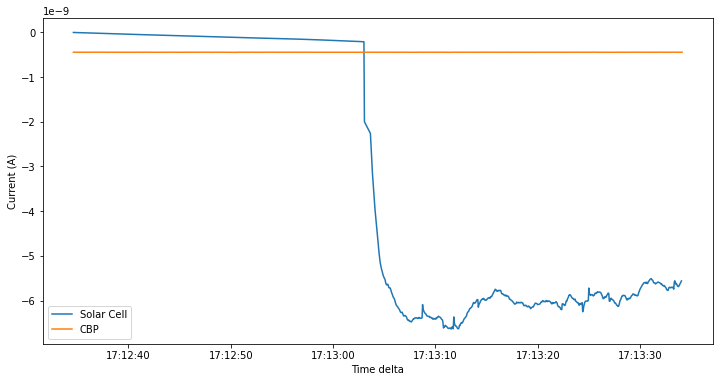

In [128]:
plt.figure(figsize=(12,6))
plt.plot(df[2].loc['time'],df[2].loc['current'], label='Solar Cell')
plt.plot(df[4].loc['time'],df[4].loc['current'], label='CBP')
plt.xlabel('Time delta')
plt.ylabel('Current (A)')
plt.legend()